In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import  preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from qiskit import providers
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA, COBYLA, GradientDescent
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap, PauliFeatureMap
from qiskit.opflow import StateFn, Gradient, I, Z
from qiskit.utils import QuantumInstance

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, OpflowQNN
from qiskit_machine_learning.utils.loss_functions import L2Loss, CrossEntropyLoss

In [2]:
df = pd.read_csv('Datasets/Mentor/mock_train_set.csv')
df.head(8)

,0,1,2,3,x
0,2789.26,1000,10,20,0
1,4040.01,1000000,1,1,1
2,2931.20,10000,10000,40,1
3,3896.54,10000,100000,30,1
4,982.06,100,1000,75,0
5,1579.81,1,1000,90,0
6,3031.77,1000000,1000000,35,1
7,860.44,10,100000,60,0


In [3]:
df_test = pd.read_csv('Datasets/Mentor/mock_test_set.csv')
df_test.head(8)

,0,1,2,3,x
0,2988.55,10000,10000,75,1
1,3413.80,1,100,90,0
2,3891.52,1,1,5,0
3,4514.99,10000,1000000,25,1
4,752.29,10,10,90,0
5,1404.13,10000,1000,5,1
6,3390.65,1000000,10000,5,1
7,2620.98,1,10,75,0


In [4]:
f_name_list = list(df)
list(f_name_list)

['0', '1', '2', '3', 'x']

In [5]:
print('Number of empty data in the set: '), df.isnull().sum().sum()
clean_data = df.dropna()

Number of empty data in the set: 


In [6]:
x_org = clean_data.drop('x', axis=1)
cat = clean_data.x

rel = ExtraTreesClassifier()
rel.fit(x_org, cat)

ExtraTreesClassifier()

In [7]:
print(rel.feature_importances_)

[0.14227843 0.48614432 0.27220423 0.09937301]


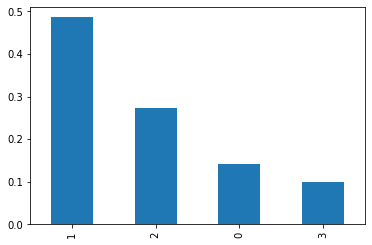

In [8]:
rank_f = pd.Series(rel.feature_importances_, index=x_org.columns)
rank_f.nlargest(20).plot(kind='bar')
plt.show()

In [9]:
corr = clean_data.iloc[:,:-1].corr()
classified = mutual_info_classif(x_org, cat)
class_data = pd.Series(classified, index=x_org.columns)
ordered_f = class_data.sort_values(ascending=False)

In [10]:
ordered_f.head(10)

1    0.323743
2    0.299295
0    0.060894
3    0.017582
dtype: float64

In [11]:
test_ratio = 0.2
seed = 1984
selected_f = clean_data[['0','1','2','3','x']]
selected_test = df_test[['0','1','2','3','x']]

x_train = np.array(selected_f.drop('x', axis =1))
y_train = np.array(selected_f.x)
x = preprocessing.normalize(x_train, axis=0)

x_test = np.array(selected_test.drop('x', axis =1))
y_test = np.array(selected_test.x)
x = preprocessing.normalize(x_test, axis=0)

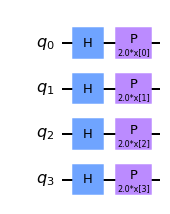

In [12]:
feature_dim = x.shape[1]
feature_map_layer = 1
ent = 'linear'

fmap = ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_layer)#, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

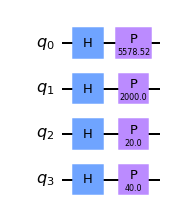

In [13]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

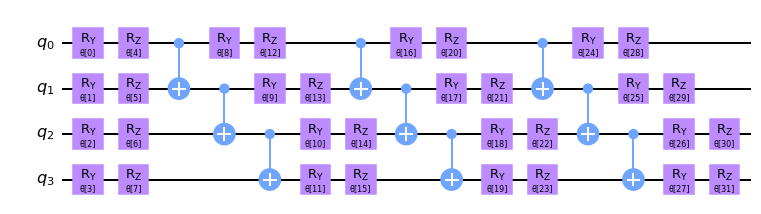

In [14]:
rotations = ['ry', 'rz']
var_form_rep = 3

ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=1)

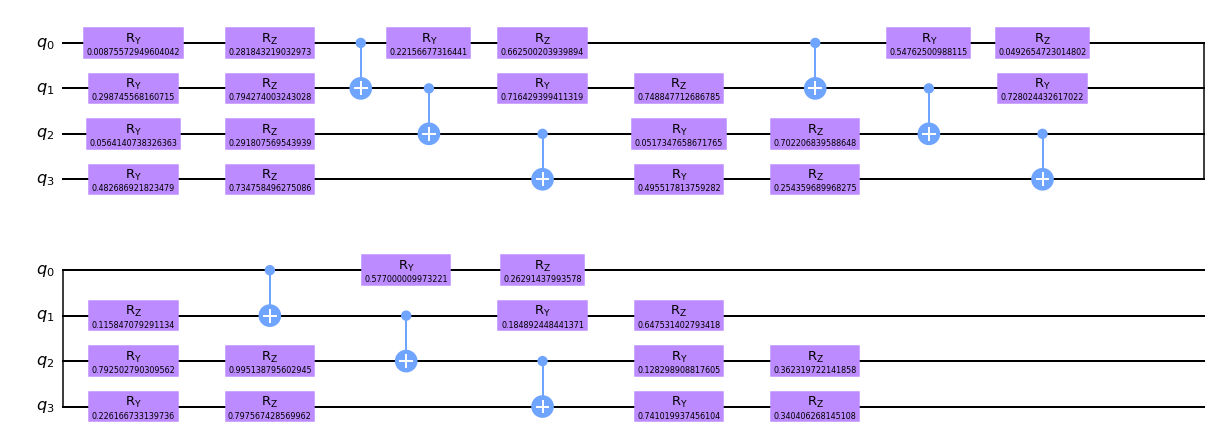

In [15]:
np.random.seed(seed)
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=1)

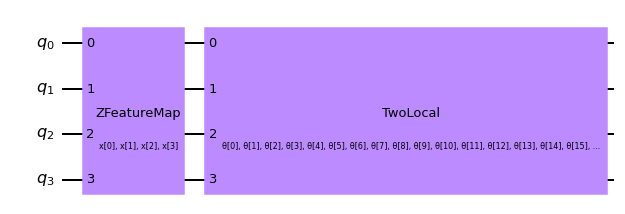

In [16]:
var_circuit = fmap.compose(ansatz_tl)
var_circuit.draw('mpl')

In [17]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [18]:
qasm_sim = Aer.get_backend('aer_simulator')
qinst = QuantumInstance(qasm_sim, 2048, seed_simulator=seed)

In [19]:
num_classes = 2
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [20]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.52099609, 0.47900391]])

In [21]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-1.54785156e-01, -2.07519531e-02,  1.09863281e-02,
          1.19628906e-02,  1.24023438e-01, -1.83105469e-02,
          2.79052734e-01, -3.66210938e-03,  2.05078125e-01,
          1.68457031e-02, -3.90625000e-03, -1.02539062e-02,
          9.74121094e-02,  5.32226563e-02,  3.22265625e-02,
         -3.17382812e-03, -1.09375000e-01,  6.90917969e-02,
          2.92968750e-03,  2.44140625e-04,  6.54296875e-02,
          7.49511719e-02,  3.41796875e-03, -4.88281250e-03,
         -6.12792969e-02, -1.22070312e-03, -3.41796875e-03,
         -9.27734375e-03,  7.32421875e-04,  6.34765625e-03,
         -7.56835938e-03,  1.68457031e-02],
        [ 1.54785156e-01,  2.07519531e-02, -1.09863281e-02,
         -1.19628906e-02, -1.24023438e-01,  1.83105469e-02,
         -2.79052734e-01,  3.66210938e-03, -2.05078125e-01,
         -1.68457031e-02,  3.90625000e-03,  1.02539062e-02,
         -9.74121094e-02, -5.32226562e-02, -3.22265625e-02,
          3.17382812e-03,  1.09375000e-01, -6.90917969e-

In [22]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels))[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

In [23]:
def callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global loss_recorder

    loss_recorder.append(fval)
    print(f'{nfev} - {fval}')

In [24]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


# x_train_norm = np.array([x/np.linalg.norm(x) for x in x_train])
# x_test_norm = np.array([x/np.linalg.norm(x) for x in x_test])

vqc = vqc.fit(x_train, y_train_1h)

3 - 362.26783457749497
6 - 356.7887845258292
9 - 307.6428732218516
12 - 314.3551045185356
15 - 293.90895395165114
18 - 293.9639575161389
21 - 294.08763090713023
24 - 294.00564423481256
27 - 293.91382809071274
30 - 293.45102807034607
33 - 292.2187816884966
36 - 292.8502513311092
39 - 290.8722921872029
42 - 290.90025650606174
45 - 290.9297991386303
48 - 289.2718187455416
51 - 289.5611355577089
54 - 289.2627398979027
57 - 288.3687162646755
60 - 287.80391353380435
63 - 284.93271209148133
66 - 276.6736807563601
69 - 276.12743044901333
72 - 271.99819573618436
75 - 272.0920559538231
78 - 261.21702001009294
81 - 256.76666391238774
84 - 254.19108520143737
87 - 253.11923762147228
90 - 250.7104151294765
93 - 250.4515636693091
96 - 241.13752730452376
99 - 241.1617605103106
102 - 238.24478051906289
105 - 237.86624612778485
108 - 237.2891299622282
111 - 233.12222212710037
114 - 229.61308321471626
117 - 226.0211498643866
120 - 223.2305672385285
123 - 221.08444702658113
126 - 219.94446083067268
129 - 

In [25]:
score_train_1 = vqc.score(x_train, y_train_1h)
score_test_1 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_1}')
print(f'Score on the test set {score_test_1}')

Score on the train set 0.7966666666666666
Score on the test set 0.8166666666666667


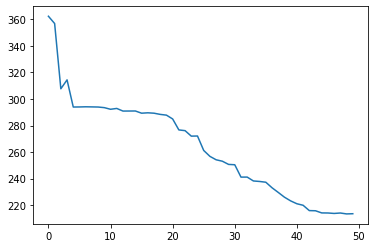

In [26]:
plt.plot(loss_recorder)

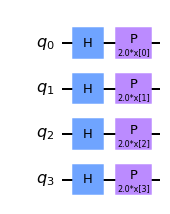

In [27]:
fmap = ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_layer)#, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

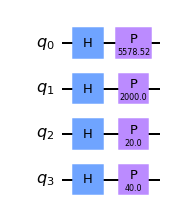

In [28]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

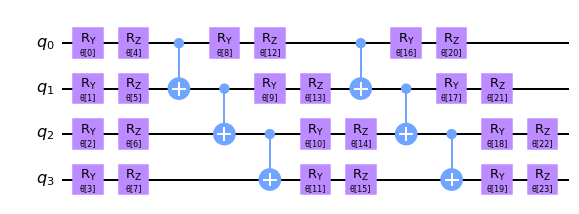

In [29]:
rotations = ['ry', 'rz']
var_form_rep = 2

ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=1)

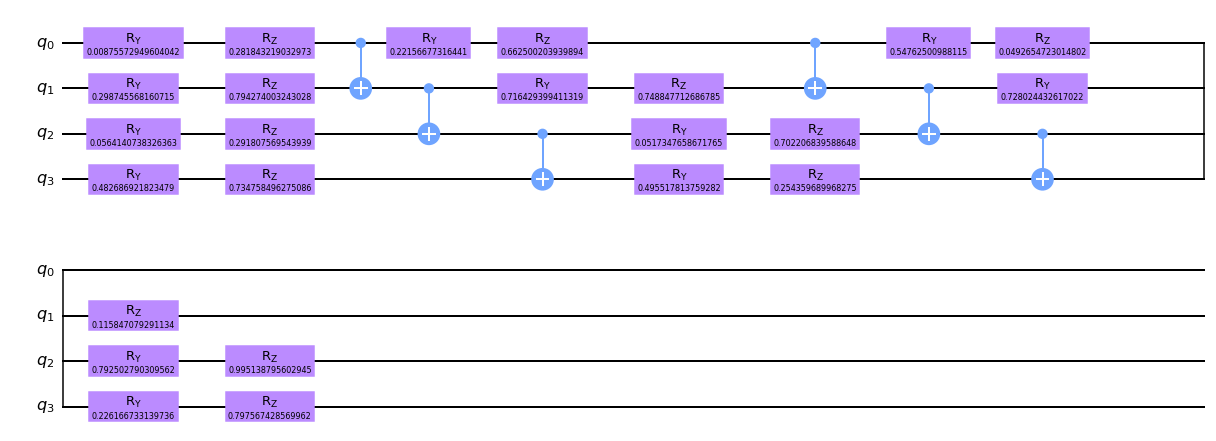

In [30]:
np.random.seed(seed)
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=1)

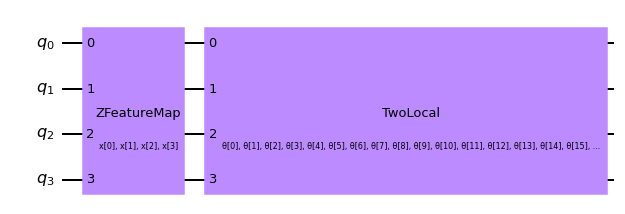

In [31]:
var_circuit = fmap.compose(ansatz_tl)
var_circuit.draw('mpl')

In [32]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [33]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.58007812, 0.41992188]])

In [34]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.2277832 ,  0.00708008,  0.00512695,  0.00439453,
          0.10302734,  0.02075195,  0.12988281, -0.00073242,
          0.29418945,  0.00390625, -0.0090332 , -0.00415039,
          0.05981445,  0.02685547, -0.01074219, -0.00292969,
         -0.07885742,  0.00708008, -0.00097656,  0.00488281,
          0.00634766, -0.01147461, -0.01074219, -0.00585938],
        [ 0.2277832 , -0.00708008, -0.00512695, -0.00439453,
         -0.10302734, -0.02075195, -0.12988281,  0.00073242,
         -0.29418945, -0.00390625,  0.0090332 ,  0.00415039,
         -0.05981445, -0.02685547,  0.01074219,  0.00292969,
          0.07885742, -0.00708008,  0.00097656, -0.00488281,
         -0.00634766,  0.01147461,  0.01074219,  0.00585938]]])

In [35]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 316.0864821738577
6 - 315.31336235419843
9 - 315.5475843906011
12 - 324.4311161661877
15 - 308.8284680630047
18 - 297.0207933207417
21 - 306.42760326905534
24 - 306.56645935703716
27 - 302.5118147811602
30 - 277.0937370796096
33 - 276.91055052476827
36 - 271.8052884576841
39 - 270.55134471755656
42 - 256.9369658415329
45 - 244.2221214354379
48 - 239.8311926408739
51 - 238.11913542733976
54 - 238.49018823904987
57 - 220.71594203614856
60 - 220.02386498069967
63 - 219.7991037215777
66 - 219.25209117592232
69 - 219.3396350751671
72 - 219.19632973444044
75 - 217.52144249421517
78 - 216.42488901873142
81 - 216.4480353622128
84 - 216.08192463785764
87 - 214.79193551388084
90 - 215.05853298951004
93 - 214.96227398818638
96 - 214.65435163566994
99 - 214.05142887691153
102 - 214.32835850730353
105 - 214.49875218502825
108 - 214.62641802757304
111 - 214.6614998435794
114 - 214.1647702455191
117 - 214.13475686152418
120 - 213.5459858183845
123 - 213.20647007223613
126 - 213.71326909651913
129

In [36]:
score_train_2 = vqc.score(x_train, y_train_1h)
score_test_2 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_2}')
print(f'Score on the test set {score_test_2}')

Score on the train set 0.7966666666666666
Score on the test set 0.8166666666666667


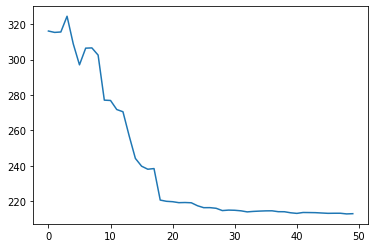

In [37]:
plt.plot(loss_recorder)

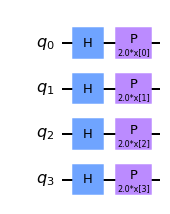

In [38]:
fmap = ZFeatureMap(feature_dimension=feature_dim, reps=feature_map_layer)#, entanglement=ent)
fmap.decompose().draw('mpl', scale=1)

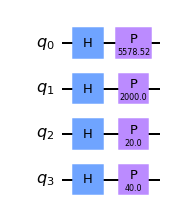

In [39]:
fmap.assign_parameters({k:v for (k,v) in zip(fmap.parameters, x_train[0])}).decompose().draw('mpl', scale=1)

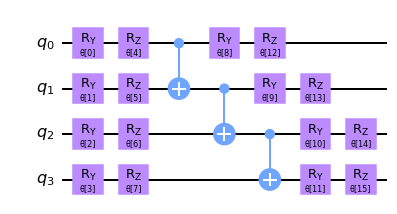

In [40]:
rotations = ['ry', 'rz']
var_form_rep = 1

ansatz_tl = TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)
ansatz_tl.decompose().draw('mpl', scale=1)

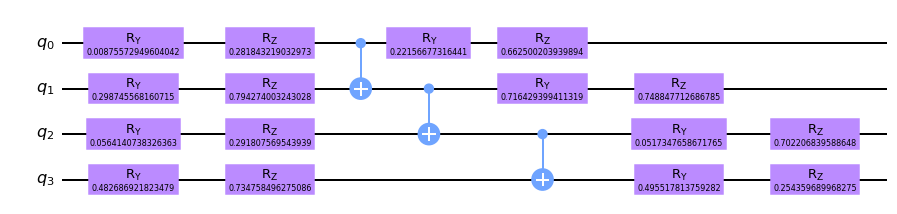

In [41]:
np.random.seed(seed)
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=1)

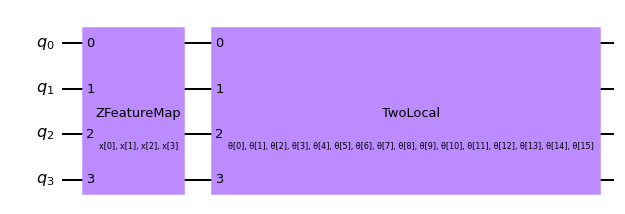

In [42]:
var_circuit = fmap.compose(ansatz_tl)
var_circuit.draw('mpl')

In [43]:
qnn = CircuitQNN(circuit=var_circuit,
                 input_params=fmap.parameters,  # if your embedding strategy is not a parametrized circuit 
                                                   # (e.g. amplitude encoding) you will have to do some extra work!
                 weight_params=ansatz_tl.parameters,  # if you train your embedding as well, the trainable
                                                      # parameters of the embedding must be added
                 interpret=one_qubit_binary,
                 output_shape=num_classes,
                 gradient=None,
                 quantum_instance=qinst)

In [44]:
output = qnn.forward(x_train[0], weights)
print(output.shape)
output

(1, 2)


array([[0.56738281, 0.43261719]])

In [45]:
_, update = qnn.backward(x_train[0], weights)
update

array([[[-0.29003906, -0.00195313,  0.00317383,  0.00268555,
          0.06616211,  0.03344727,  0.00097656, -0.00048828,
          0.34301758,  0.00878906,  0.00952148,  0.00146484,
         -0.01293945,  0.00390625, -0.00219727, -0.01391602],
        [ 0.29003906,  0.00195313, -0.00317383, -0.00268555,
         -0.06616211, -0.03344727, -0.00097656,  0.00048828,
         -0.34301758, -0.00878906, -0.00952148, -0.00146484,
          0.01293945, -0.00390625,  0.00219727,  0.01391602]]])

In [46]:
max_itr = 50
spsa_opt = SPSA(maxiter=max_itr, callback=callback)
loss_recorder = []
np.random.seed(seed)
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)


vqc = vqc.fit(x_train, y_train_1h)

3 - 358.8970431052113
6 - 318.1759045803168
9 - 359.94128405066556
12 - 319.05643968775064
15 - 354.0040013857393
18 - 463.6171730077227
21 - 372.10329822219177
24 - 373.11856564180994
27 - 344.35833348066126
30 - 314.9694114637616
33 - 319.8910498926259
36 - 356.38832849307755
39 - 328.10758733739203
42 - 326.7164638403822
45 - 311.14243784554213
48 - 308.4799430188459
51 - 301.3054026636689
54 - 300.56980952893144
57 - 300.5460993448457
60 - 298.78978068708636
63 - 298.3744197317138
66 - 296.62672038701044
69 - 296.55613836913085
72 - 296.8858694601361
75 - 296.8892463228473
78 - 296.5729002106636
81 - 296.37251050621325
84 - 296.39306944599423
87 - 296.40674970169056
90 - 296.4095632491594
93 - 296.5383278373379
96 - 296.1953837132386
99 - 296.21436534932036
102 - 296.08592417815555
105 - 296.07175100682645
108 - 296.17341369511706
111 - 296.0287818276271
114 - 296.20340429727
117 - 296.24295100670906
120 - 296.23382449316387
123 - 296.17627746749974
126 - 296.12100331513216
129 - 2

In [47]:
score_train_3 = vqc.score(x_train, y_train_1h)
score_test_3 = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train_3}')
print(f'Score on the test set {score_test_3}')

Score on the train set 0.5433333333333333
Score on the test set 0.5166666666666667


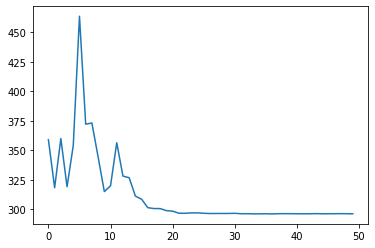

In [48]:
plt.plot(loss_recorder)